In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from methods import *

dataset_path = Path("dataset")
dataset = LabeledDataset(dataset_path=dataset_path)
dataset_unchanged = LabeledDataset(dataset_path=dataset_path, uniform_size=False, new_size=None)

Rozdział na SPLIT1/SPLIT2 train/val/test

In [3]:
splits = [Split(*dataset_unchanged.split_dataset()), Split(*dataset.split_dataset())]

Augmentacja train dataset poprzez rotacje (chwilę trwa, lepiej wczytać już wygenerowany)

In [4]:
import shutil
import scipy.ndimage

train = splits[1].train

def augment(data):
    rotations_per_image = 2
    augment_count = len(data)

    rng = np.random.default_rng(seed=666_666)

    label_sizes = {Label.PAPER: augment_count // 3, Label.ROCK: augment_count // 3}
    label_sizes[Label.SCISSORS] = augment_count - sum(label_sizes.values())

    random_images = {
        label: rng.choice(data[label], size=label_sizes[label], replace=False)
        for label in Label
    }

    def rotate(image, angle):
        return scipy.ndimage.rotate(image, angle, reshape=False, mode="nearest")

    import time
    start = time.time()

    augmented_images = {
        label: [
            rotate(image, angle) for image in random_images[label] for angle in rng.choice(range(1, 360), size=rotations_per_image)
            ] for label in Label
        }
    print(time.time() - start)
    return augmented_images

augmented_dir = Path("dataset/augmented")
force_gen = False

if force_gen == False and augmented_dir.exists():
    augmented = LabeledDataset(dataset_path=augmented_dir)
else:
    augmented = augment(train)
    shutil.rmtree(augmented_dir, ignore_errors=True)
    for label, images in augmented.items():
        label_dir = augmented_dir / label.name.lower()
        label_dir.mkdir(parents=True, exist_ok=True)
        index = 1
        for image in images:
            cv2.imwrite(str(label_dir / f'{index:04}.png'), image)
            index += 1
        for image in train[label]:
            cv2.imwrite(str(label_dir / f'{index:04}.png'), image)
            index += 1

    augmented = LabeledDataset(dataset_path=augmented_dir)

splits[1] = Split(augmented.copy(), splits[1].val, splits[1].test)

Normalizacja

In [5]:
_, mean, std = splits[1].train.normalize(inplace=True)
_, _, _ = splits[1].val.normalize(mean=mean, std=std, inplace=True)
_, _, _ = splits[1].test.normalize(mean=mean, std=std, inplace=True)

(200, 200)


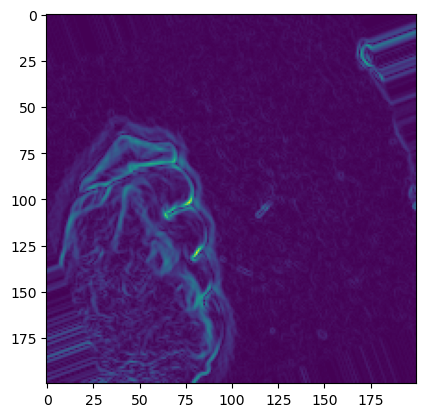

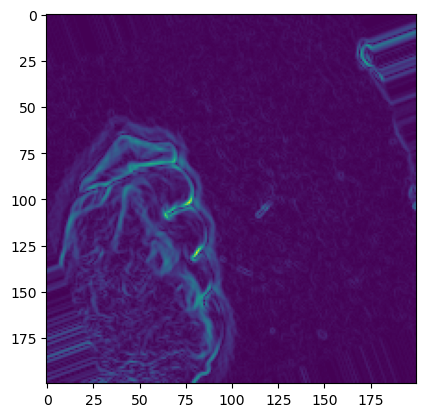

In [12]:
import skimage.filters as sk_filters
img = dataset[1000]
img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#plt.imshow(img_grey, cmap='grey', vmin=0, vmax=255)
#plt.show()
#plt.imshow(sk_filters.sobel(img))
#plt.show()
train_dat = splits[1].train[0]
print(train_dat.shape)
scharr = sk_filters.scharr(img_grey)
plt.imshow(splits[1].train[0])
_ = plt.show()

stwórz SPLIT3

In [7]:
rng = np.random.default_rng(seed=999)
split3_val = {
    label: rng.choice(splits[1].train[label], size=len(splits[1].val[label]), replace=False)
    for label in Label}

ranges = np.cumsum([0, *[len(split3_val[label]) for label in Label]])
ranges = {label: Range(start ,end) for label, (start, end) in zip(Label, zip(ranges, ranges[1::]))}
split3_val = LabeledDataset(_dataset=(np.vstack(list(split3_val.values())), ranges))
splits.append(Split(splits[1].train, split3_val, splits[1].test))

In [8]:
from pathlib import Path

splits_path = Path(f"dataset/splits")
splits_path.mkdir(exist_ok=True)
for i, split in enumerate(splits):
    split_path = splits_path / f"split_{i+1}"
    split_path.mkdir(exist_ok=True)
    for set, set_dataset in zip(split._fields, split):
        set_path = split_path / f"{set}"
        set_path.mkdir(exist_ok=True)
        for label in Label:
            label_path = set_path / label.name
            np.save(label_path, set_dataset[label])

Liczba danych wejściowych (przed i po obróbce (scale & uniform)):

In [9]:
from tabulate import tabulate
counts = {
        label.name: [
            len(dataset_unchanged[label]),
            len(dataset[label]),
            len(splits[0].train[label]),
            len(splits[0].val[label]),
            len(splits[0].test[label]),
            len(splits[1].train[label]),
            len(splits[1].val[label]),
            len(splits[1].test[label]),
            len(splits[2].train[label]),
            len(splits[2].val[label]),
            len(splits[2].test[label]),
        ]
        for label in Label
    }
counts["TOTAL"] = [sum(column) for column in zip(*counts.values())]


counts = [[key, *counts[key]] for key in counts.keys()]

print(tabulate(counts, headers=[
    "LABEL", "przed obróbką", "po obróbce", *[f"split{i+1} {split_set}" for i in range(3) for split_set in ["train", "val", "test"]]
    ]))

LABEL       przed obróbką    po obróbce    split1 train    split1 val    split1 test    split2 train    split2 val    split2 test    split3 train    split3 val    split3 test
--------  ---------------  ------------  --------------  ------------  -------------  --------------  ------------  -------------  --------------  ------------  -------------
ROCK                  726           712             508           145             73            1494           142             72            1494           142             72
PAPER                 712           712             498           142             72            1494           142             72            1494           142             72
SCISSORS              750           712             525           150             75            1494           142             72            1494           142             72
TOTAL                2188          2136            1531           437            220            4482           426           

Kilka losowo wybranych zdjęć:

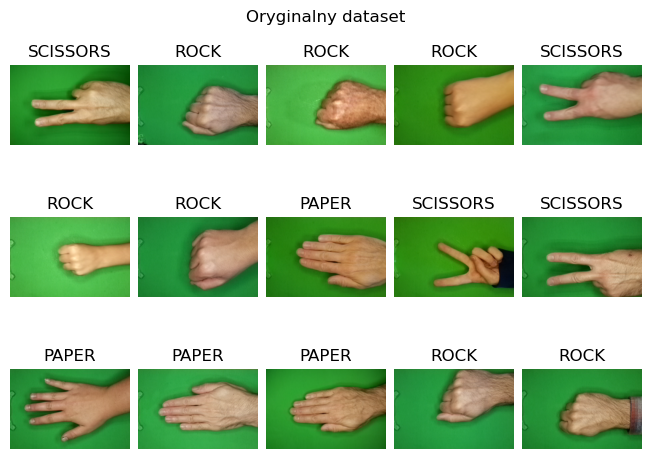

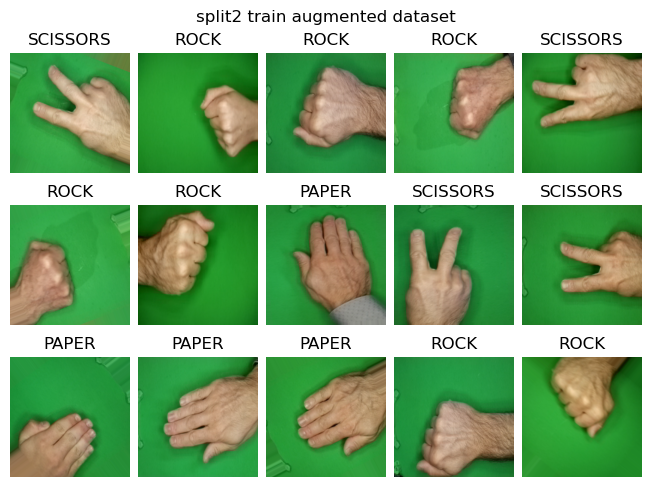

In [10]:
def draw_random_images(data, title):
    fig, ax = plt.subplots(3,5, constrained_layout=True)
    fig.suptitle(title)
    rng = np.random.default_rng(seed=2222)
    random_indices = rng.choice(len(data), 5*3)
    for row in range(3):
        for col in range(5):
            index = row*5 + col
            ax[row][col].set_axis_off()
            random_image = data[random_indices[index]]
            ax[row][col].imshow(random_image[...,::-1])
            for label, label_range in data._label_ranges.items():
                if label_range.start <= random_indices[index] < label_range.end:
                    ax[row][col].set_title(label.name)
                    break

draw_random_images(dataset_unchanged, "Oryginalny dataset")
draw_random_images(augmented, "split2 train augmented dataset")